In [59]:
import numpy as np
import pandas as pd

''' data cleanning '''
import texthero as hero
from texthero import preprocessing

''' model building '''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

''' plotting '''
import matplotlib
import matplotlib.pyplot as plt

''' text evaluations '''
from eli5.lime import TextExplainer
from sklearn.preprocessing import FunctionTransformer
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
import eli5

plt.style.use('classic')
matplotlib.rcParams['figure.figsize'] = (20, 10)

In [6]:
# columns that we use
cols = ['EventDescription','IncidentCause','IncidentConsequence', 'Category']

# importing file
df = pd.read_csv('..\..\cleaned_incidents1.csv', usecols=cols)

# drop missing category
df = df.dropna(axis=0, subset=['Category'])

# replace the rest with empty string
df = df.replace(np.nan, '', regex=True)

In [7]:
# Text Cleaning and Pre-processing
def preprocess_text(features):
    # cleaning steps
    cleaning_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_whitespace,
        preprocessing.remove_punctuation,
        preprocessing.remove_urls,
        preprocessing.remove_brackets,
        preprocessing.remove_stopwords,
        preprocessing.remove_digits,
        preprocessing.remove_angle_brackets,
        preprocessing.remove_curly_brackets,
        preprocessing.stem
    ]

    # apply pipeline to text
    clean_text = features.pipe(hero.clean, cleaning_pipeline)
    
    return clean_text

In [8]:
# cleaning the data
df['description'] = df['EventDescription'] + ' ' + df['IncidentCause']+ ' ' + df['IncidentConsequence']
df['description'] = preprocess_text(df['description'])

le = LabelEncoder()
Y = le.fit_transform(df['Category'])

num_rows = df.shape[0]
indices = range(num_rows)

# splitting of data in test and train
x_train, x_test_original, y_train, y_test, indices_train,indices_test = train_test_split(df['description'],Y, indices, test_size=0.25, random_state = 42)

# vectorize
tfidf = TfidfVectorizer(analyzer='word', max_features=500)

tfidf.fit_transform(df['description']).toarray()
x_train = tfidf.transform(x_train)
x_test = tfidf.transform(x_test_original)

# resampling
oversample = SMOTE(random_state=0,n_jobs=-1,k_neighbors=3)
x_train, y_train = oversample.fit_resample(x_train, y_train)

In [9]:
# convert to dense matrix for PCA
x_train_dense = x_train.todense()
x_test_dense = x_test.todense()

# convert training data to PCA to visualize in 2 D
pca = PCA(n_components = 2)
x_train_pca = pca.fit_transform(x_train_dense)

# convert test data to PCA
x_test_pca = pca.fit_transform(x_test_dense)

target_names =  le.classes_

In [50]:
plt.style.use('classic')
matplotlib.rcParams['figure.figsize'] = (20, 10)

# remove outliers to limit the regions area
def remove_outliers(data, dataset):
    # calculate interquartile range
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q75 - q25
    #print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    
    # identify outliers
    outliers = [x for x in data if x < lower or x > upper]
    #print('Identified outliers: %d' % len(outliers))
    
    # remove outliers 
    filter_indices = np.logical_and(data >= lower, data <= upper)

    outliers_removed = [x for x in data if x >= lower and x <= upper]
    #print('Non-outlier observations: %d' % len(outliers_removed))
    
    return dataset[filter_indices]

# draw decision boundary
def draw_decision_boundary (X, y, X_test, y_test, model, plot_title, few_points=False):
    colors_region=["purple", "cyan", "brown", "red", "grey", "yellow", "maroon", "gold", "orange", "olive", "green", "deeppink", "darkkhaki", "navy", "black"]
    colors=["purple", "gold", "deeppink", "red", "yellow", "grey", "maroon", "black", "cyan", "orange", "brown", "darkgrey", "green", "darkkhaki", "navy"]

    h = .01  # step size in the mesh

    clf = model.fit(X, y)

    X = remove_outliers(X[:,0], X)
    
    # create a mesh to plot in
    x_min, x_max = X[:, 0].min()-0.3, X[:, 0].max()+0.3
    y_min, y_max = X[:, 1].min()-0.3, X[:, 1].max()+0.3
     
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, 15, colors=colors_region)

    plt.axis('tight')
    # Plot also the points
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y_test == i)    
        if few_points:
            lineWidth=3
            s=50
        else:
            lineWidth=0
            s=20
        plt.scatter(X_test[idx, 0], X_test[idx, 1], c=color, label=target_names[i],
            edgecolor='black', s=s, linewidth=lineWidth)
    plt.title("Decision surface of multi-class %s" %plot_title)
    plt.axis('tight')

    # Plot the three one-against-all classifiers
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    # change legend colors
    l = plt.legend()
    i = 0
    for text in l.get_texts():
        text.set_color(colors[i])
        i+=1
    plt.show()
    
# get data for particular Category
# X can be training data or test data
# y is target training data or target test data
def get_specific_category_data(category_code, X, y):
    filter_indices = np.where(y == category_code)

    #get all instances with specific Category
    x_class = X[filter_indices] 
    y_class = y[filter_indices]

    return x_class, y_class

# find index of an array in multi-dimensional arrays
def get_index(arrays, search_array):
    index = 0
    for a in arrays:
        if (a==search_array).all():
            print('Found')
            return index
        index=index + 1
    print('Not found')
    return index

# ------- Logistic Regression --------

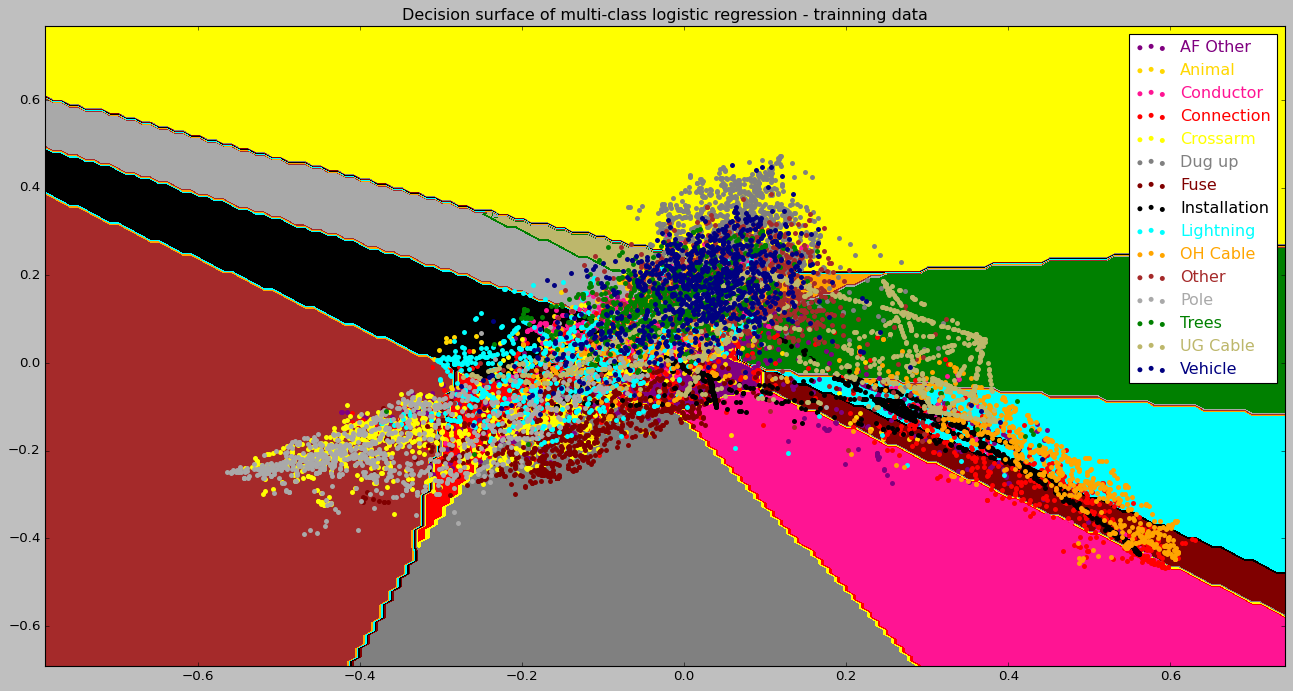

In [12]:
# draw decision boundary for logistic regression with all training data
# initiate model for pca
lr = LogisticRegression(random_state=0, max_iter= 130)

draw_decision_boundary (x_train_pca, y_train, x_train_pca, y_train, lr, 'logistic regression - trainning data')

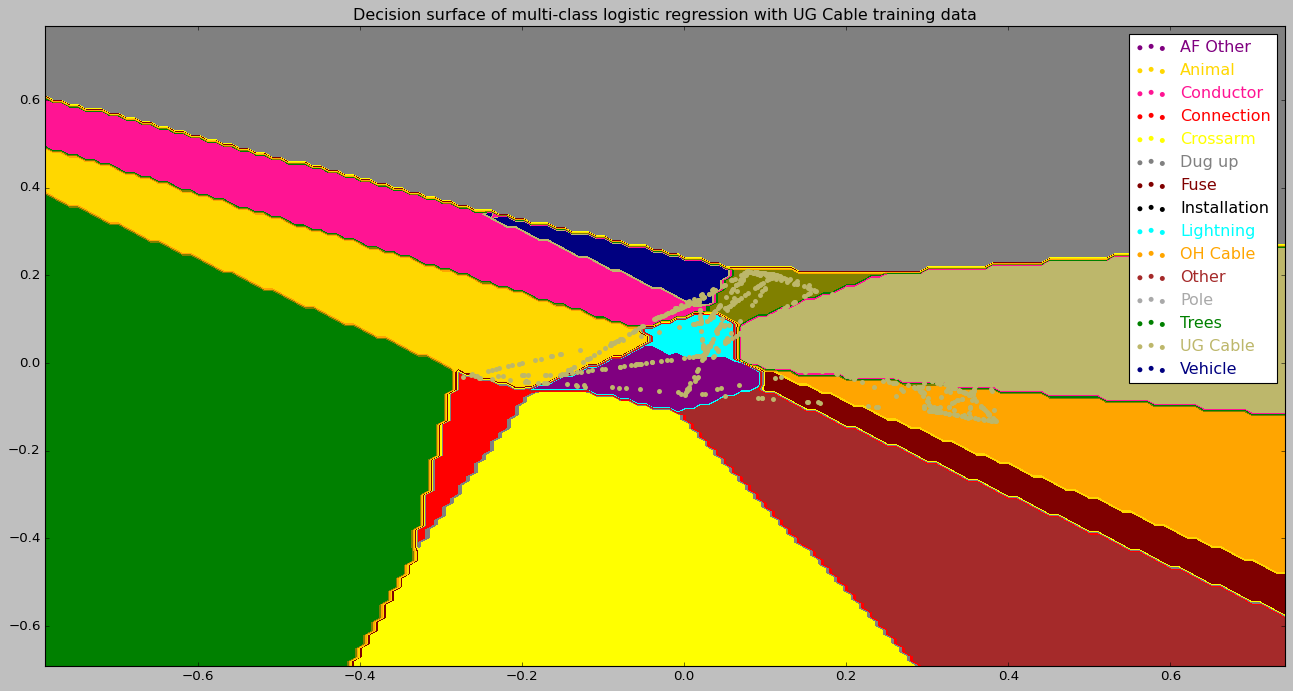

In [52]:
# draw decision boundary for logistic regression with UG Cable training data

x_train_specific, y_train_specific = get_specific_category_data(13, x_train_pca, y_train)
draw_decision_boundary (x_train_pca, y_train, x_train_specific, y_train_specific, lr, 'logistic regression with UG Cable training data')

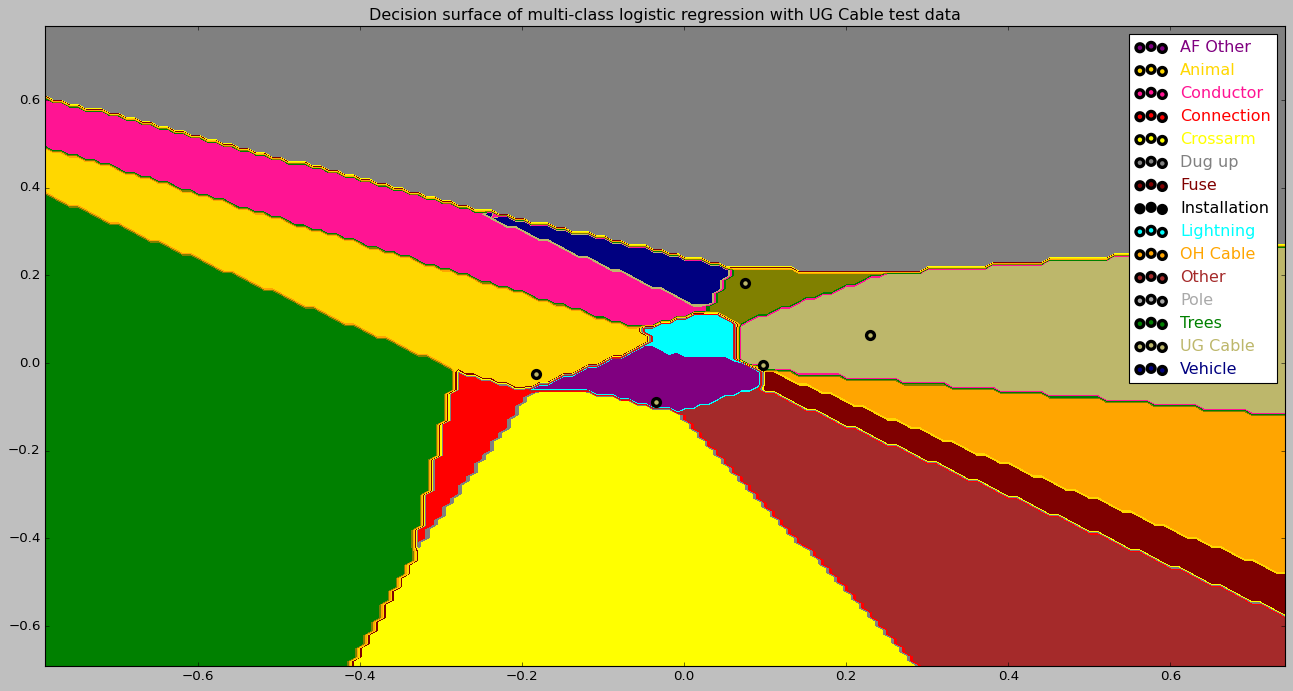

In [53]:
# draw decision boundary for logistic regression with UG Cable test data

x_test_specific, y_test_specific = get_specific_category_data(13, x_test_pca, y_test)
draw_decision_boundary (x_train_pca, y_train, x_test_specific, y_test_specific, lr, 'logistic regression with UG Cable test data', True)

In [15]:
# pick one of misclassification instance
print('x_test:', x_test_specific)

print('y_test:', y_test_specific)

y_pred = lr.predict(x_test_specific)
print('y_pred:', y_pred)

# get a mis-classification instance
x_misclassified = x_test_specific[2]
print('mis-classified x: ', x_misclassified)

x_test: [[ 0.22976724  0.06504462]
 [-0.18288403 -0.02489745]
 [-0.03500761 -0.0891158 ]
 [ 0.09675348 -0.00421396]
 [ 0.07474063  0.18388157]]
y_test: [13 13 13 13 13]
y_pred: [13  8  0 13 10]
mis-classified x:  [-0.03500761 -0.0891158 ]


In [ ]:
# find the index of misclassified instance in x_test after pca
index = get_index(x_test_pca, x_misclassified)
print('index in x_test:', index)

# find the index of misclassified instance in x_test after tfidf
text_after_cleaning = x_test_original.to_numpy()[index]
print()
print('text after cleaning:')
print(text_after_cleaning)
print()
print('y:', y_test[index])

index_in_df = indices_test[index]
print('index in df:', index_in_df)
print()
print('Text in df:')
print(df.iloc[index_in_df,0])

# You need to add 2 in order to find this text in excel file

# ------- Random Forest --------

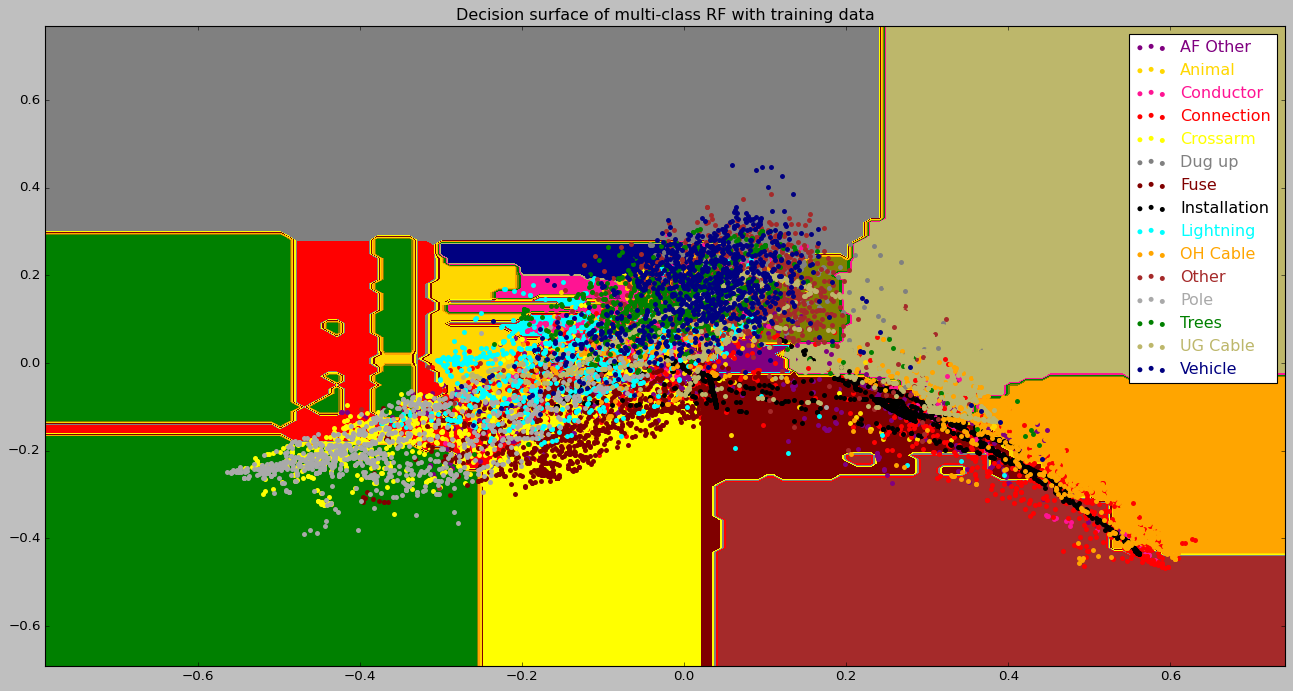

In [54]:
# random forest decision boundary for training data
rf = RandomForestClassifier(random_state=0, n_estimators=800, max_depth=20, min_samples_leaf=50, max_features='sqrt', criterion='gini', n_jobs=-1)
draw_decision_boundary (x_train_pca, y_train, x_train_pca, y_train, rf, 'RF with training data')

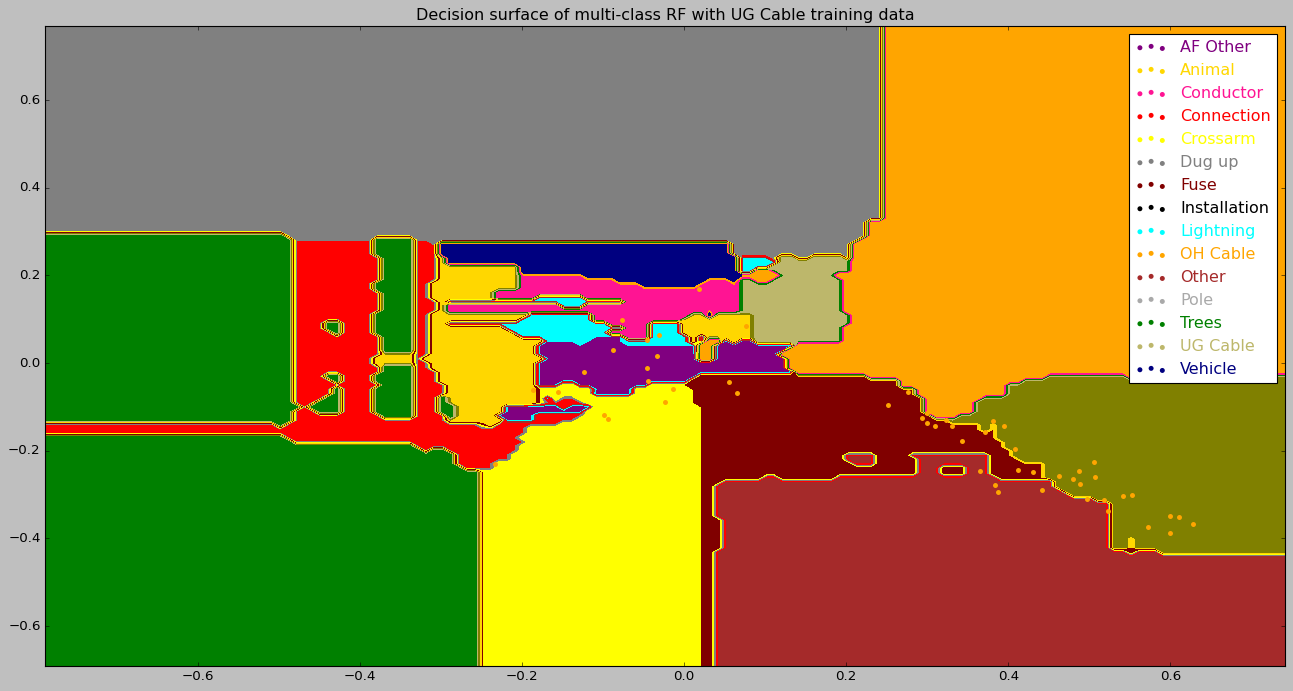

In [45]:
# random forest decision boundary for trainning data minority class
x_test_specific2, y_test_specific2 = get_specific_category_data(9, x_test_pca, y_test)
draw_decision_boundary (x_train_pca, y_train, x_test_specific2, y_test_specific2, rf, 'RF with UG Cable training data')

In [55]:
# prepare test data for RF model NOTE: this is only for visualization purpose
# randomly choose data

x_ugCable = np.array([x_train_specific[10], 
                      x_train_specific[69],
                      x_train_specific[81],
                      x_train_specific[150],
                      x_train_specific[218],
                      x_train_specific[226]
                     ])
y_ugCable = [13,13,13,13,13,13]
y_pred = rf.predict(x_ugCable)

x_misclassified = x_ugCable[0]
print('misclassified:', x_misclassified)

# find the index of misclassified instance in x_test after pca
index = get_index(x_train_pca, x_misclassified)
print('index in x_test:', index)

index_in_df = indices_train[index]
print('index in df:', index_in_df)
print()
print('Text in df:')
print(df.iloc[index_in_df,0])

misclassified: [ 0.38447953 -0.13307014]
Found
index in x_test: 2945
index in df: 3178

Text in df:
Melbourne Water plumbers were working on water pipes located in the nature strip. The plumber working on the metallic pipes  received an electric shock when he made contact with the metallic pipe and direct contact with the general mass of earth. The plumber who had received the electric shock was not on-site at the time of investigation and was not contactable.


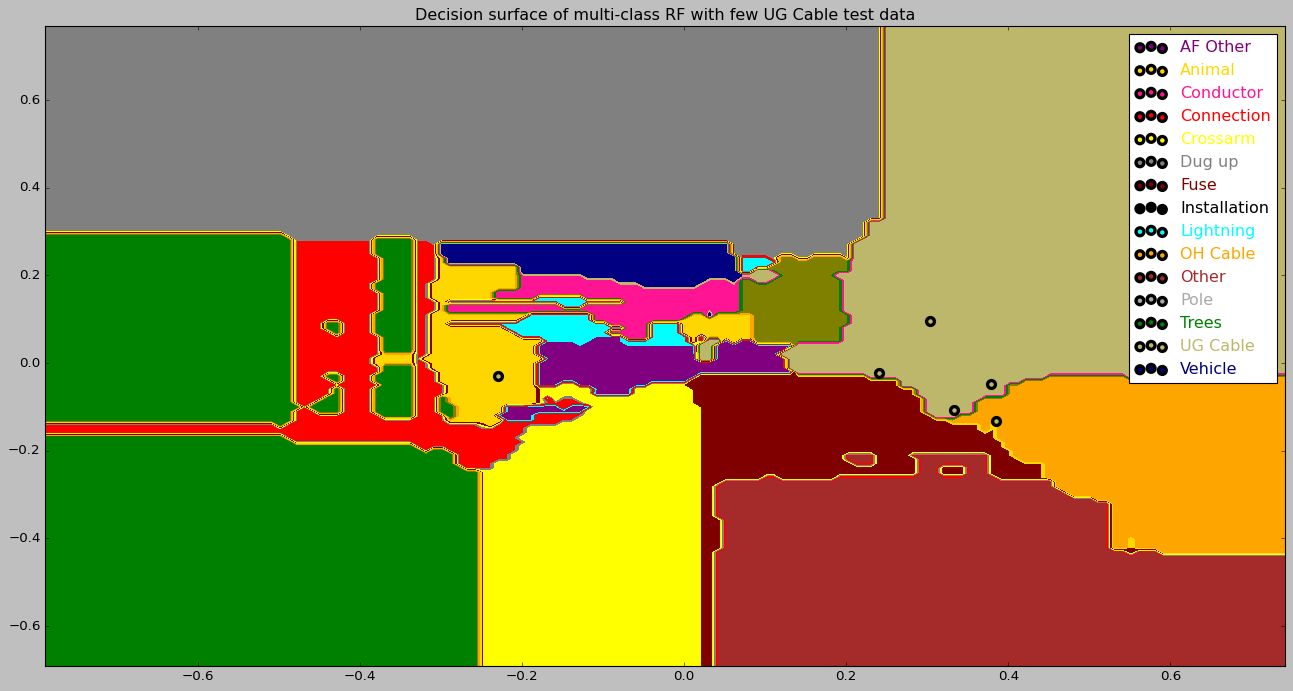

In [56]:
# ramdom forest decision boundary for UG cable
draw_decision_boundary (x_train_pca, y_train, x_ugCable, y_ugCable, rf, 'RF with few UG Cable test data', True)

# ------- XGBoost --------

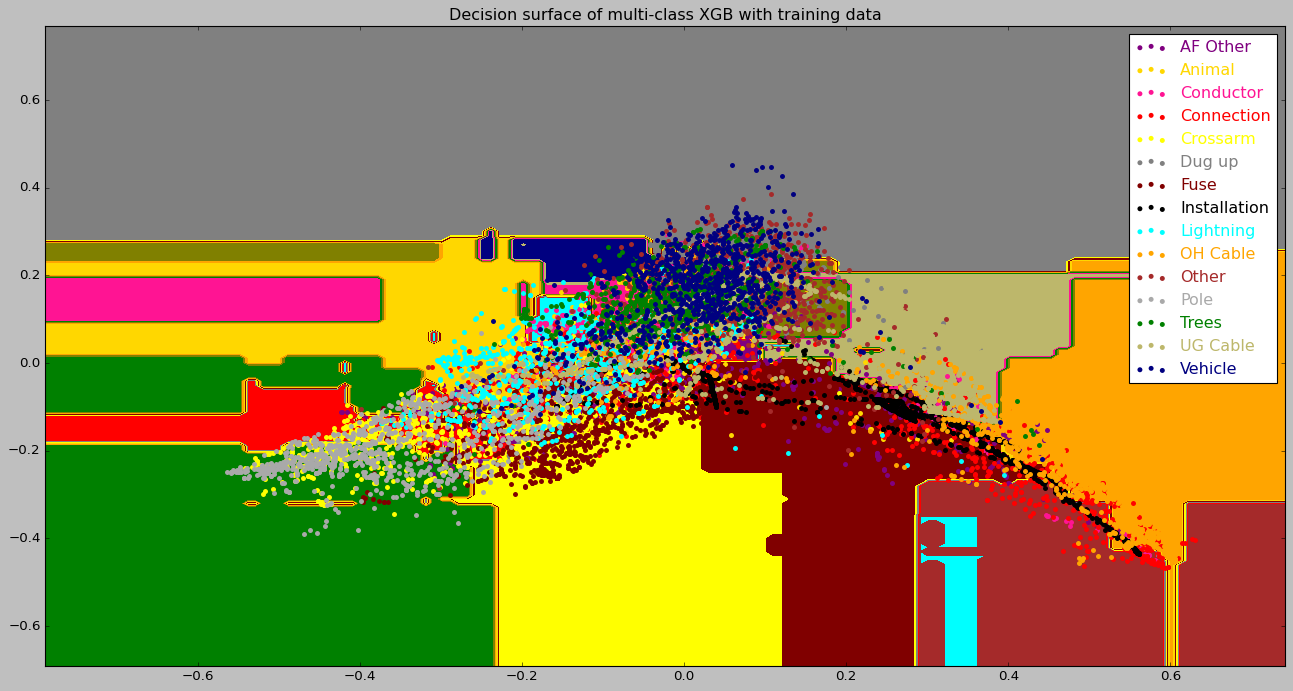

In [60]:
# XGBoost decision boundary for training data
xgb = XGBClassifier(random_state=4, num_class=15, early_stopping_rounds=10)
draw_decision_boundary (x_train_pca, y_train, x_train_pca, y_train, xgb, 'XGB with training data')

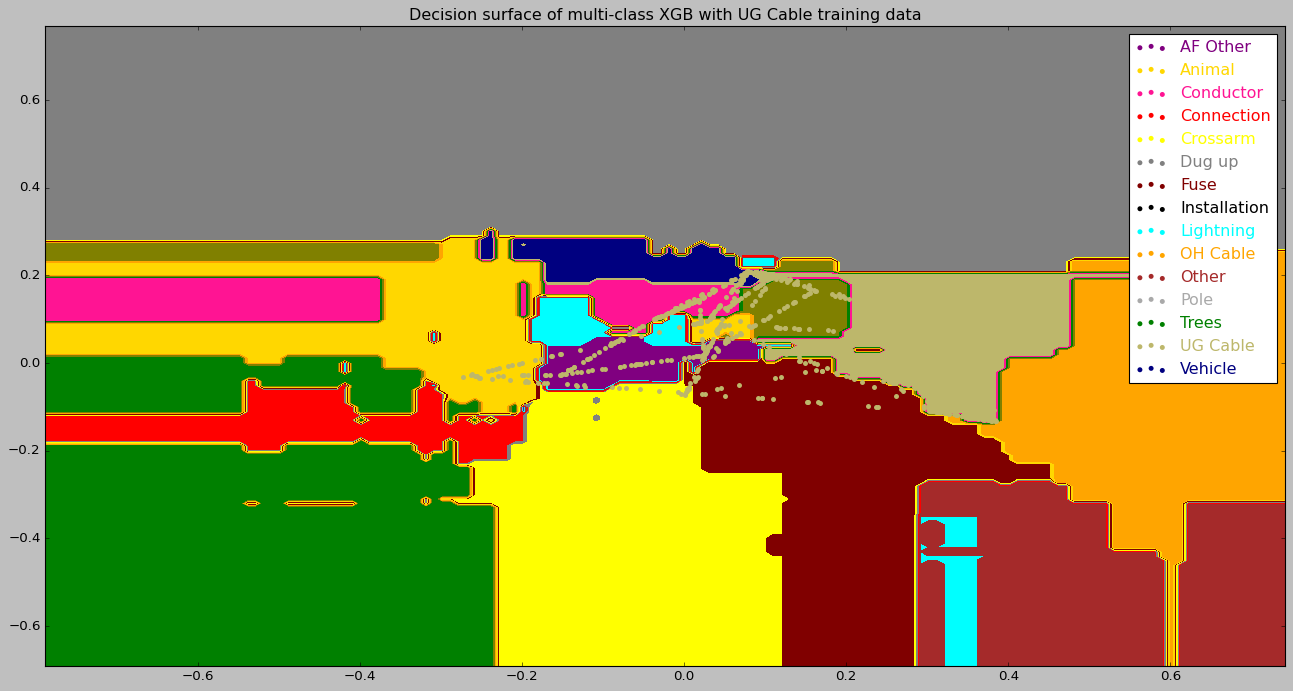

In [61]:
# XGBoost decision boundary for trainning data minority class
draw_decision_boundary (x_train_pca, y_train, x_train_specific, y_train_specific, xgb, 'XGB with UG Cable training data')

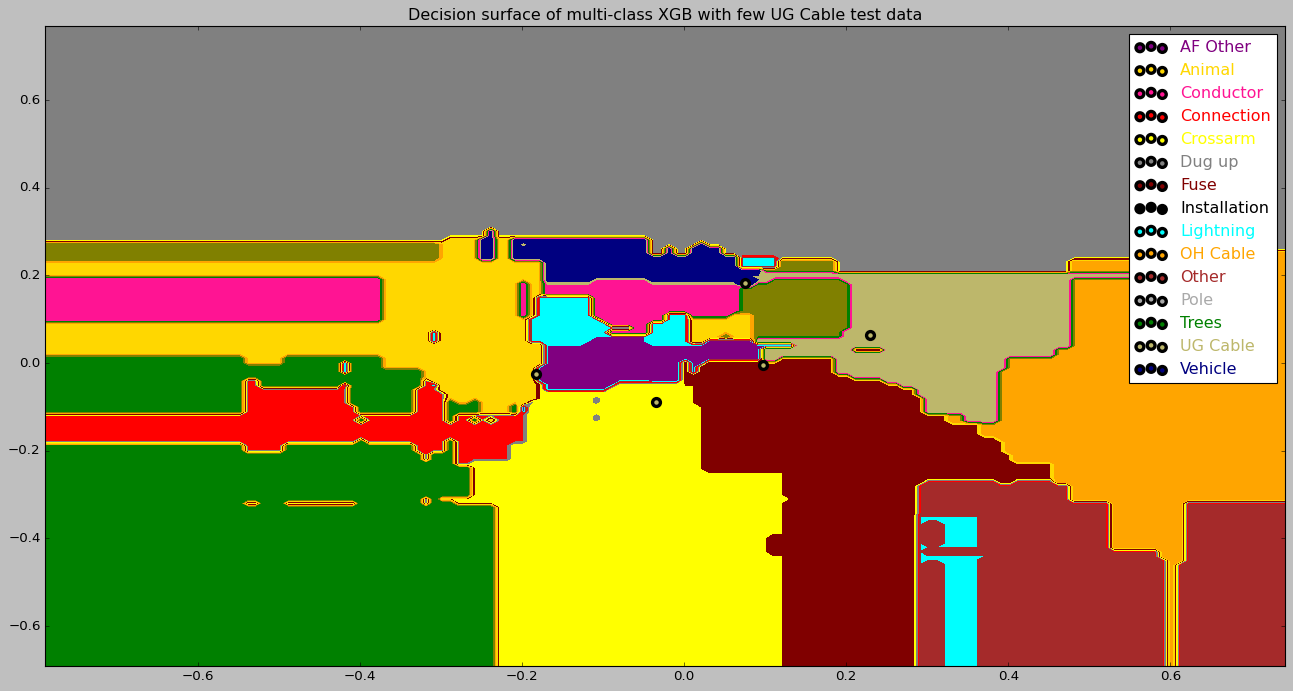

In [62]:
# XGBoost decision boundary for quater of test data minority class
draw_decision_boundary (x_train_pca, y_train, x_test_specific, y_test_specific, xgb, 'XGB with few UG Cable test data', True)

# ------- Text Evaluation using LIME --------

In [34]:
# model explanation using ELI5

""":arg
x_test -- > text (without tfidf)
y_test --> test truth values
y_train --> train truth values
model -- > classifier such as rf, svm
vectorizer --> fitted tfidf vectorizer

"""
print('index_in_df:', index_in_df)

#df_sample = df.filter(like = str(index), axis=0)
series_test = df.loc[index_in_df]
df_test = pd.DataFrame(series_test).transpose()
_text = df_test['EventDescription'] + ' ' + df_test['IncidentCause'] + ' ' + df_test['IncidentConsequence']
_text = _text.tolist()
print('Text: ', _text)

_label = df_test['Category']
print('Label: ', _label)

classes = le.classes_

model = RandomForestClassifier(random_state=0, n_estimators=800, max_depth=20, min_samples_leaf=50, max_features='sqrt', criterion='gini', n_jobs=-1)
model.fit(x_train, y_train)

def clean_text(text):
    text = pd.Series(text)

    # cleaning steps
    cleaning_pipeline = [
        preprocessing.fillna,
        preprocessing.lowercase,
        preprocessing.remove_whitespace,
        preprocessing.remove_punctuation,
        preprocessing.remove_urls,
        preprocessing.remove_brackets,
        preprocessing.remove_stopwords,
        preprocessing.remove_digits,
        preprocessing.remove_angle_brackets,
        preprocessing.remove_curly_brackets,
        preprocessing.stem
    ]

    # apply pipeline to text
    processed_text = text.pipe(hero.clean, cleaning_pipeline)

    return processed_text.tolist()

cleaned_txt = clean_text(_text[0])
print(cleaned_txt)

transformer = FunctionTransformer(clean_text)
txt_clf = make_pipeline(transformer, tfidf,  model)
te = TextExplainer(random_state=42)
te.fit(cleaned_txt[0], txt_clf.predict_proba)
te.show_prediction(target_names=list(np.unique(classes)), top=10, preserve_density=True, highlight_spaces=True, horizontal_layout=True)

index_in_df: 3178
Text:  ['Melbourne Water plumbers were working on water pipes located in the nature strip. The plumber working on the metallic pipes  received an electric shock when he made contact with the metallic pipe and direct contact with the general mass of earth. The plumber who had received the electric shock was not on-site at the time of investigation and was not contactable. Faulty service. Minor shock']
Label:  3178    UG Cable
Name: Category, dtype: object
['melbourn water plumber work water pipe locat natur strip plumber work metal pipe receiv electr shock made contact metal pipe direct contact general mass earth plumber receiv electr shock site time investig contact faulti servic minor shock']


In [38]:
# lime explanation
explainer = LimeTextExplainer(class_names=classes)
exp = explainer.explain_instance(_text[0], txt_clf.predict_proba, num_features=10, labels=classes, top_labels=15)
exp.show_in_notebook(text=True)
exp.save_to_file('sample_explained.html')

In [39]:
# find prediction
txt_clf.predict(cleaned_txt[0])
le.inverse_transform(txt_clf.predict(cleaned_txt[0]))

array(['OH Cable'], dtype=object)